In [1]:
!pip install einops
%load_ext autoreload
%autoreload 2

import seaborn as sns
from dataclasses import dataclass
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from hdst import HDST
import torch
import gc
import numpy as np

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)


## Create Args Configuration Class

In [2]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 200

    run_name: str = ""
    batch_size: int = 16
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 50
    window_size: int = 20

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [3]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0.33,
        'global_vatiant_contrast': 0.33,
        'dynamic_trend_pred': 0.34,
    },
    eval=False,
    batch_size=32,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

## Load your data
You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.
Choosing from "UCR", "UEA", "ECG" and "HAR" (ECG and HAR are not available right now)

### UCR
There are 128 UCR Time Series Classification datasets under UCR folder. Choose one to load.

In [ ]:
train_data, train_labels, test_data, test_labels = datautils.load_UCR("ACSF1")
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")

### UEA
There are 30 multivariate UEA Time Series Classification datasets under UEA folder. Choose one to load.

In [4]:
train_data, train_labels, test_data, test_labels = datautils.load_UEA("AtrialFibrillation")
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")

Shapes - train data: (15, 640, 2), test data: (15, 640, 2)


## Create and Train the model

In [5]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

12

In [6]:
import time
start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (15, 640, 2)
Epoch #0: loss=2.6060452461242676
Epoch #1: loss=2.790367603302002
Epoch #2: loss=2.5673162937164307
Epoch #3: loss=2.579359769821167
Epoch #4: loss=2.565676212310791
Epoch #5: loss=2.547593116760254
Epoch #6: loss=2.523077964782715
Epoch #7: loss=2.544933319091797
Epoch #8: loss=2.5110695362091064
Epoch #9: loss=2.489795446395874
Epoch #10: loss=2.4702415466308594
Epoch #11: loss=2.459918975830078
Epoch #12: loss=2.4439103603363037
Epoch #13: loss=2.4257798194885254
Epoch #14: loss=2.4186747074127197
Epoch #15: loss=2.4045932292938232
Epoch #16: loss=2.399014472961426
Epoch #17: loss=2.3740293979644775
Epoch #18: loss=2.3643035888671875
Epoch #19: loss=2.3630001544952393
Epoch #20: loss=2.347736120223999
Epoch #21: loss=2.353487730026245
Epoch #22: loss=2.34149169921875
Epoch #23: loss=2.342567205429077
Epoch #24: loss=2.3189587593078613
Epoch #25: loss=2.324443817138672
Epoch #26: loss=2.3308908939361572
Epoch #27: loss=2.2996582984924316
Epoch #28: 

Save model and loss log

In [7]:
import torch
torch.save(model, 'mymodel.pth')
import pandas as pd
df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
df.to_csv("loss_log.csv", index=False)

Visualize the loss curve and save figure

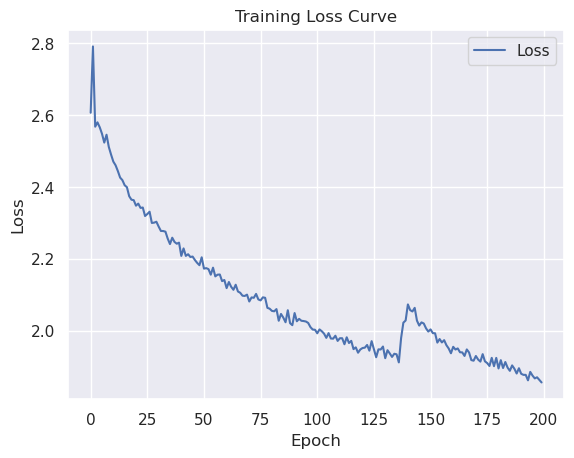

In [8]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a simple classifier (svm) using training representation and corresponding training labels. Finally, use the classifier to do calssification for test representation. Report the acc and auprc.

In [9]:
from tasks import _eval_protocols as eval_protocols
train_repr = model.encode(train_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
test_repr = model.encode(test_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
fit_clf = eval_protocols.fit_svm
clf = fit_clf(train_repr, train_labels)
acc = clf.score(test_repr, test_labels)
y_score = clf.decision_function(test_repr)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
test_labels_onehot = label_binarize(test_labels, classes=np.arange(train_labels.max()+1))
auprc = average_precision_score(test_labels_onehot, y_score)
print( 'acc:', acc, 'auprc:', auprc )

acc: 0.4666666666666667 auprc: 0.3915506715506715
